In [1]:
# since there might be some random process going on so fix them
seed = 42

# 1. Before applying ML

## Importing and re-formating data

First, we need to import the data we have obtained.  
1. match or battle log data: `{p1 pokemon, p2 pokemon, did p1 win?, URL}`  
2. base stats of each pokemon: `{'Id', 'Name', 'Type(s)', 'TotalBS', 'HP', 'Attack', 'Defense', 'Special Attack', 'Special Defense', 'Speed'}`  

<mark>Q: should pl pokemon be the pokemon which moves first in the match? it is very ambiguous to have pl pokemon just picked by system randomly.</mark>  
A: randonly picked could be better, if p1 always move first then there will be an implicit variable

In [2]:
import json

# 1. match or battle log data
with open('./data/match_ok.json', 'r') as f:
    matches = json.load(f)
# 2. base stats of each pokemon
with open('./data/baseStats.json', 'r') as f:
    baseStats = json.load(f)

# to see how they look like
print(matches[3])
print(baseStats[3])

{'pokemon1': 'arcanine', 'pokemon2': 'sharpedo', 'pokemon1 wins': 1, 'url': 'https://replay.pokemonshowdown.com/destiny-challengecup1v1-550920.log'}
{'Id': 3, 'Name': 'Mega Venusaur', 'Type(s)': ['GRASS', 'POISON'], 'TotalBS': '625', 'HP': '80', 'Attack': '100', 'Defense': '123', 'Special Attack': '122', 'Special Defense': '120', 'Speed': '80'}



Then we need to construct the features and labels from these 2 databases,  
into a format looks like: `{'p1HP' ,'p1ATK' ,'p1DEF' ,'p1SpATK' ,'p1SpDEF' ,'p1SPD' ,'p2HP' ,'p2ATK' ,'p2DEF' ,'p2SpATK' ,'p2SpDEF' ,'p2SPD' ,'p1wins'}`

In [3]:
data = []
nameNotFound = []
N = len(matches)
for idx, match in enumerate(matches):  # from each match
    # extracting battle info of each match
    p1_pokemon = match['pokemon1']
    p2_pokemon = match['pokemon2']
    p1_wins = match['pokemon1 wins']
    # searching for the baseStats given the names of pokemons 
    info = [i for i in baseStats if p1_pokemon == i['Name'].lower() or p2_pokemon == i['Name'].lower()]  # this give [dict{p1 pokemon}, dict{p2 pokemon}]
    # creating new row format
    if len(info) == 2:  # for some reason some of the match contains pokemons that can't be found
        row = {
            'p1HP': int(info[0]['HP']),
            'p1ATK' : int(info[0]['Attack']),
            'p1DEF' : int(info[0]['Defense']),
            'p1SpATK' : int(info[0]['Special Attack']),
            'p1SpDEF' : int(info[0]['Special Defense']),
            'p1SPD' : int(info[0]['Speed']),
            'p2HP' : int(info[1]['HP']),
            'p2ATK' : int(info[1]['Attack']),
            'p2DEF' : int(info[1]['Defense']),
            'p2SpATK' : int(info[1]['Special Attack']),
            'p2SpDEF' : int(info[1]['Special Defense']),
            'p2SPD' : int(info[1]['Speed']),
            'p1wins': p1_wins
            }   
        data.append(row)  # store in a list
    else: 
        case = {'match index': idx, 'pokemon1': p1_pokemon, 'pokemon2': p2_pokemon, 'URL': match['url']}
        nameNotFound.append(case)
    print(f'{idx+1}/{N} done', end="\r")

print(f'\n{len(data)} rows of data can be proceeded, \n{len(nameNotFound)} rows of data went missing')

8895/8895 done
8475 rows of data can be proceeded, 
420 rows of data went missing


Seems like the problem of missing data is due to p1_pokemon is the same as p2_pokemon.  
<mark>Q: are repeated pokemons bad data?</mark>  
A: include them

In [4]:
data = []
nameNotFound = []
N = len(matches)
for idx, match in enumerate(matches):  # from each match
    # extracting battle info of each match
    p1_pokemon = match['pokemon1']
    p2_pokemon = match['pokemon2']
    p1_wins = match['pokemon1 wins']
    # searching for the baseStats given the names of pokemons 
    p1_info = [i for i in baseStats if p1_pokemon == i['Name'].lower()] # this give [dict{p1 pokemon}, dict{p2 pokemon}]
    p2_info = [i for i in baseStats if p2_pokemon == i['Name'].lower()]
    # creating new row format
    if len(info) == 2:  # for some reason some of the match contains pokemons that can't be found
        row = {
            'p1HP': int(p1_info[0]['HP']),
            'p1ATK' : int(p1_info[0]['Attack']),
            'p1DEF' : int(p1_info[0]['Defense']),
            'p1SpATK' : int(p1_info[0]['Special Attack']),
            'p1SpDEF' : int(p1_info[0]['Special Defense']),
            'p1SPD' : int(p1_info[0]['Speed']),
            'p2HP' : int(p2_info[0]['HP']),
            'p2ATK' : int(p2_info[0]['Attack']),
            'p2DEF' : int(p2_info[0]['Defense']),
            'p2SpATK' : int(p2_info[0]['Special Attack']),
            'p2SpDEF' : int(p2_info[0]['Special Defense']),
            'p2SPD' : int(p2_info[0]['Speed']),
            'p1wins': p1_wins
            }   
        data.append(row)  # store in a list
    else: 
        case = {'match index': idx, 'pokemon1': p1_pokemon, 'pokemon2': p2_pokemon, 'URL': match['url']}
        nameNotFound.append(case)
    print(f'{idx+1}/{N} done', end="\r")

print(f'\n{len(data)} rows of data can be proceeded, \n{len(nameNotFound)} rows of data went missing')

8895/8895 done
8895 rows of data can be proceeded, 
0 rows of data went missing


Convert them into pandas DataFrame for better visualistion and statistics summaries.  

In [5]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data)
df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins
0,100,150,120,120,100,90,50,75,75,65,65,50,1
1,85,73,70,73,115,67,80,80,90,110,130,110,1
2,66,41,77,61,87,23,100,120,100,150,120,90,0
3,90,110,80,100,80,95,70,120,40,95,40,95,1
4,115,140,130,55,55,40,85,50,95,120,115,80,0


## Statistics explanations 
1. `df.info` gives data-type  
2. `df.describe()` gives general statisticial parameters 
2. `df.corr()` gives relationships between each features 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895 entries, 0 to 8894
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   p1HP     8895 non-null   int64
 1   p1ATK    8895 non-null   int64
 2   p1DEF    8895 non-null   int64
 3   p1SpATK  8895 non-null   int64
 4   p1SpDEF  8895 non-null   int64
 5   p1SPD    8895 non-null   int64
 6   p2HP     8895 non-null   int64
 7   p2ATK    8895 non-null   int64
 8   p2DEF    8895 non-null   int64
 9   p2SpATK  8895 non-null   int64
 10  p2SpDEF  8895 non-null   int64
 11  p2SPD    8895 non-null   int64
 12  p1wins   8895 non-null   int64
dtypes: int64(13)
memory usage: 903.5 KB


In [7]:
df.describe()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins
count,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000
mean,83.387071,94.795728,87.156268,87.858235,86.651490,80.329623,83.086116,94.907813,86.887015,87.542215,86.424171,80.001012,0.515346
std,28.965276,30.744319,28.686207,29.702127,24.461876,27.136546,28.308613,30.615940,28.388273,29.608771,24.493733,27.364288,0.499793
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.000000
25%,68.000000,75.000000,70.000000,60.000000,71.000000,60.000000,68.000000,75.000000,70.000000,60.000000,71.000000,60.000000,0.000000
50%,80.000000,95.000000,85.000000,95.000000,90.000000,80.000000,80.000000,95.000000,85.000000,95.000000,90.000000,80.000000,1.000000
75%,95.000000,120.000000,100.000000,109.000000,100.000000,100.000000,95.000000,120.000000,100.000000,109.000000,100.000000,100.000000,1.000000
max,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,1.000000


In [8]:
df.corr()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins
p1HP,1.000000,0.159947,-0.096941,0.083385,0.238906,-0.039596,0.143618,0.053386,0.060914,0.072099,0.096891,0.034027,0.003795
p1ATK,0.159947,1.000000,0.340554,0.072528,-0.107900,0.148736,0.035741,0.116347,0.097640,0.105880,0.070354,0.053487,0.022386
p1DEF,-0.096941,0.340554,1.000000,-0.039379,0.286547,-0.241989,0.046364,0.088601,0.124544,0.091824,0.105191,0.065789,0.029719
p1SpATK,0.083385,0.072528,-0.039379,1.000000,0.308170,0.428495,0.039296,0.064959,0.062657,0.126207,0.079051,0.076659,0.023403
p1SpDEF,0.238906,-0.107900,0.286547,0.308170,1.000000,-0.008397,0.103116,0.072984,0.089669,0.116202,0.154881,0.079008,0.031678
p1SPD,-0.039596,0.148736,-0.241989,0.428495,-0.008397,1.000000,0.027351,0.052950,0.062895,0.046753,0.041396,0.046416,-0.013206
p2HP,0.143618,0.035741,0.046364,0.039296,0.103116,0.027351,1.000000,0.191733,-0.044455,0.094240,0.249209,-0.024842,-0.036172
p2ATK,0.053386,0.116347,0.088601,0.064959,0.072984,0.052950,0.191733,1.000000,0.320980,0.060110,-0.091258,0.165982,-0.050329
p2DEF,0.060914,0.097640,0.124544,0.062657,0.089669,0.062895,-0.044455,0.320980,1.000000,-0.004456,0.315424,-0.228035,-0.035772
p2SpATK,0.072099,0.105880,0.091824,0.126207,0.116202,0.046753,0.094240,0.060110,-0.004456,1.000000,0.313862,0.432299,-0.041853


done
___

## Feature engineering
- the BaseStats difference between pokemon 1 and pokemon 2
- the BaseStats difference between attack and defence features 

In [9]:
df['p1ATKp2DEF'] = df['p1ATK'] - df['p2DEF']
df['p2ATKp1DEF'] = df['p2ATK'] - df['p1DEF']

df['p1SpATKp2SpDEF'] = df['p1SpATK'] - df['p2SpDEF']
df['p2SpATKp1SpDEF'] = df['p2SpATK'] - df['p1SpDEF']

df['p1SPDp2SPD'] = df['p1SPD'] - df['p2SPD']

df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF,p1SPDp2SPD
0,100,150,120,120,100,90,50,75,75,65,65,50,1,75,-45,55,-35,40
1,85,73,70,73,115,67,80,80,90,110,130,110,1,-17,10,-57,-5,-43
2,66,41,77,61,87,23,100,120,100,150,120,90,0,-59,43,-59,63,-67
3,90,110,80,100,80,95,70,120,40,95,40,95,1,70,40,60,15,0
4,115,140,130,55,55,40,85,50,95,120,115,80,0,45,-80,-60,65,-40


## Statistics explanations 
1. `df.info` gives data-type  
2. `df.describe()` gives general statisticial parameters 
2. `df.corr()` gives relationships between each features 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895 entries, 0 to 8894
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   p1HP            8895 non-null   int64
 1   p1ATK           8895 non-null   int64
 2   p1DEF           8895 non-null   int64
 3   p1SpATK         8895 non-null   int64
 4   p1SpDEF         8895 non-null   int64
 5   p1SPD           8895 non-null   int64
 6   p2HP            8895 non-null   int64
 7   p2ATK           8895 non-null   int64
 8   p2DEF           8895 non-null   int64
 9   p2SpATK         8895 non-null   int64
 10  p2SpDEF         8895 non-null   int64
 11  p2SPD           8895 non-null   int64
 12  p1wins          8895 non-null   int64
 13  p1ATKp2DEF      8895 non-null   int64
 14  p2ATKp1DEF      8895 non-null   int64
 15  p1SpATKp2SpDEF  8895 non-null   int64
 16  p2SpATKp1SpDEF  8895 non-null   int64
 17  p1SPDp2SPD      8895 non-null   int64
dtypes: int64(18)
memory usage: 1

In [11]:
df.describe() 

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF,p1SPDp2SPD
count,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000,8895.000000
mean,83.387071,94.795728,87.156268,87.858235,86.651490,80.329623,83.086116,94.907813,86.887015,87.542215,86.424171,80.001012,0.515346,7.908713,7.751546,1.434064,0.890725,0.328612
std,28.965276,30.744319,28.686207,29.702127,24.461876,27.136546,28.308613,30.615940,28.388273,29.608771,24.493733,27.364288,0.499793,39.757645,40.057527,36.974823,36.148803,37.633260
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.000000,-220.000000,-220.000000,-220.000000,-220.000000,-170.000000
25%,68.000000,75.000000,70.000000,60.000000,71.000000,60.000000,68.000000,75.000000,70.000000,60.000000,71.000000,60.000000,0.000000,-15.000000,-15.000000,-25.000000,-25.000000,-25.000000
50%,80.000000,95.000000,85.000000,95.000000,90.000000,80.000000,80.000000,95.000000,85.000000,95.000000,90.000000,80.000000,1.000000,9.000000,9.000000,4.000000,3.000000,0.000000
75%,95.000000,120.000000,100.000000,109.000000,100.000000,100.000000,95.000000,120.000000,100.000000,109.000000,100.000000,100.000000,1.000000,35.000000,35.000000,25.000000,25.000000,24.000000
max,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,1.000000,140.000000,176.000000,125.000000,118.000000,195.000000


In [12]:
df.corr()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF,p1SPDp2SPD
p1HP,1.000000,0.159947,-0.096941,0.083385,0.238906,-0.039596,0.143618,0.053386,0.060914,0.072099,0.096891,0.034027,0.003795,0.080191,0.110225,0.002799,-0.102613,-0.053294
p1ATK,0.159947,1.000000,0.340554,0.072528,-0.107900,0.148736,0.035741,0.116347,0.097640,0.105880,0.070354,0.053487,0.022386,0.703575,-0.154955,0.011657,0.159741,0.068358
p1DEF,-0.096941,0.340554,1.000000,-0.039379,0.286547,-0.241989,0.046364,0.088601,0.124544,0.091824,0.105191,0.065789,0.029719,0.174419,-0.648407,-0.101316,-0.118695,-0.222330
p1SpATK,0.083385,0.072528,-0.039379,1.000000,0.308170,0.428495,0.039296,0.064959,0.062657,0.126207,0.079051,0.076659,0.023403,0.011347,0.077848,0.750940,-0.105165,0.253238
p1SpDEF,0.238906,-0.107900,0.286547,0.308170,1.000000,-0.008397,0.103116,0.072984,0.089669,0.116202,0.154881,0.079008,0.031678,-0.147465,-0.149422,0.144955,-0.581521,-0.063504
p1SPD,-0.039596,0.148736,-0.241989,0.428495,-0.008397,1.000000,0.027351,0.052950,0.062895,0.046753,0.041396,0.046416,-0.013206,0.070107,0.213764,0.316790,0.043977,0.687328
p2HP,0.143618,0.035741,0.046364,0.039296,0.103116,0.027351,1.000000,0.191733,-0.044455,0.094240,0.249209,-0.024842,-0.036172,0.059381,0.113339,-0.133520,0.007412,0.037786
p2ATK,0.053386,0.116347,0.088601,0.064959,0.072984,0.052950,0.191733,1.000000,0.320980,0.060110,-0.091258,0.165982,-0.050329,-0.139220,0.700850,0.112636,-0.000153,-0.082509
p2DEF,0.060914,0.097640,0.124544,0.062657,0.089669,0.062895,-0.044455,0.320980,1.000000,-0.004456,0.315424,-0.228035,-0.035772,-0.638528,0.156135,-0.158618,-0.064329,0.211163
p2SpATK,0.072099,0.105880,0.091824,0.126207,0.116202,0.046753,0.094240,0.060110,-0.004456,1.000000,0.313862,0.432299,-0.041853,0.085058,-0.019815,-0.106533,0.740447,-0.280625


## Data cleaning 
- just drop nan and drop duplicates

In [13]:
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900 entries, 0 to 8893
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   p1HP            6900 non-null   int64
 1   p1ATK           6900 non-null   int64
 2   p1DEF           6900 non-null   int64
 3   p1SpATK         6900 non-null   int64
 4   p1SpDEF         6900 non-null   int64
 5   p1SPD           6900 non-null   int64
 6   p2HP            6900 non-null   int64
 7   p2ATK           6900 non-null   int64
 8   p2DEF           6900 non-null   int64
 9   p2SpATK         6900 non-null   int64
 10  p2SpDEF         6900 non-null   int64
 11  p2SPD           6900 non-null   int64
 12  p1wins          6900 non-null   int64
 13  p1ATKp2DEF      6900 non-null   int64
 14  p2ATKp1DEF      6900 non-null   int64
 15  p1SpATKp2SpDEF  6900 non-null   int64
 16  p2SpATKp1SpDEF  6900 non-null   int64
 17  p1SPDp2SPD      6900 non-null   int64
dtypes: int64(18)
memory usage: 1

skipped
___

## Train-test-split
1. separate X and y
2. convert to numpy array
3. split

In [14]:
y = df['p1wins'].to_numpy()  # using [[]] is to convert pd.series into pd.DataFrame, so than when converted to numpy it will have the shape of (n, 1) instead of (n, )
X = df.loc[ :, df.columns != 'p1wins' ].to_numpy()

print(f"x shape: {X.shape}\ny shape: {y.shape}")

x shape: (6900, 17)
y shape: (6900,)


In [15]:
from sklearn.model_selection import train_test_split

split_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size, random_state=seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size, random_state=seed, shuffle=True)

print(f'train set: \nX: {X_train.shape}, y: {y_train.shape}\ntest set: \nX: {X_test.shape}, y: {y_test.shape}\nvalidation set: \nX: {X_val.shape}, y: {y_val.shape}')

train set: 
X: (4416, 17), y: (4416,)
test set: 
X: (1104, 17), y: (1104,)
validation set: 
X: (1380, 17), y: (1380,)


In [16]:
df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF,p1SPDp2SPD
0,100,150,120,120,100,90,50,75,75,65,65,50,1,75,-45,55,-35,40
1,85,73,70,73,115,67,80,80,90,110,130,110,1,-17,10,-57,-5,-43
2,66,41,77,61,87,23,100,120,100,150,120,90,0,-59,43,-59,63,-67
3,90,110,80,100,80,95,70,120,40,95,40,95,1,70,40,60,15,0
4,115,140,130,55,55,40,85,50,95,120,115,80,0,45,-80,-60,65,-40


done
___

## Normalisation and Standardisation 

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

done
___

## Statistics explanations 


In [18]:
import statsmodels.api as smf

model = smf.Logit(y_train, X_train_scaled).fit_regularized()
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6899439071256475
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4416
Model:                          Logit   Df Residuals:                     4399
Method:                           MLE   Df Model:                           16
Date:                Sat, 12 Jun 2021   Pseudo R-squ.:                0.004616
Time:                        21:04:17   Log-Likelihood:                -3046.8
converged:                       True   LL-Null:                       -3060.9
Covariance Type:            nonrobust   LLR p-value:                   0.02944
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0116      0.034     -0.347      0.729      -0.077       0.054
x2             0.0179   4.13e+06   4.32e-09      1.000   -8.09e+06    8.09e+06
x3             0.0030        nan        nan        nan         nan         nan
x4             0.0275        nan        nan        nan         nan         nan
x5             0.0225        nan        nan        nan         nan         nan
x6            -0.0315        nan        nan        nan         nan         nan
x7            -0.0372      0.033     -1.121      0.262      -0.102       0.028
x8            -0.0512        nan        nan        nan         nan         nan
x9             0.0093   3.97e+06   2.33e-09      1.000   -7.78e+06    7.78e+06
x10           -0.0338        nan        nan        nan         nan         nan
x11           -0.0283        nan        nan        nan         nan         nan
x12            0.0050        nan        nan        nan         nan         nan
x13            0.0146   5.51e+06   2.66e-09      1.000   -1.08e+07    1.08e+07
x14           -0.0475        nan        nan        nan         nan         nan
x15            0.0430        nan        nan        nan         nan         nan
x16           -0.0422        nan        nan        nan         nan         nan
x17           -0.0235        nan        nan        nan         nan         nan
==============================================================================
"""

<a href="https://stats.stackexchange.com/questions/401751/why-do-i-get-nan-for-p-values-while-using-statsmodels-logit-function">read this to see why some p-values are nan</a>

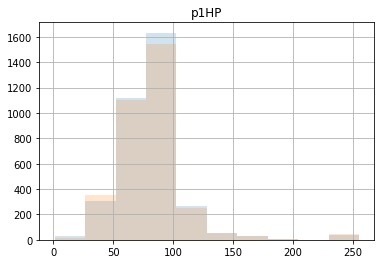

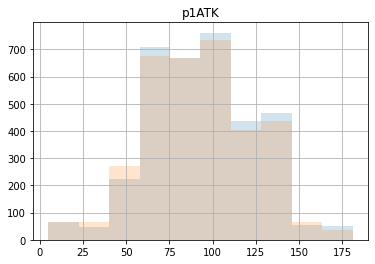

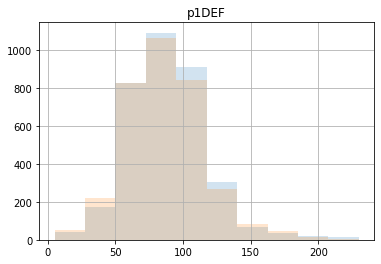

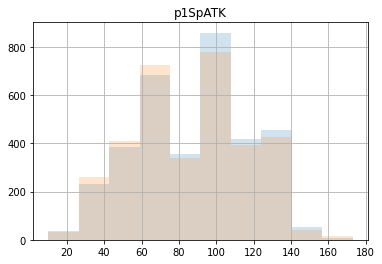

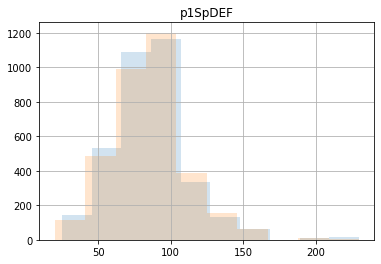

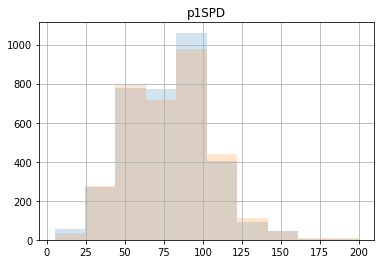

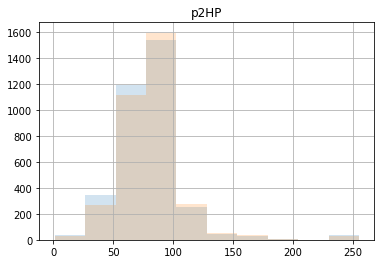

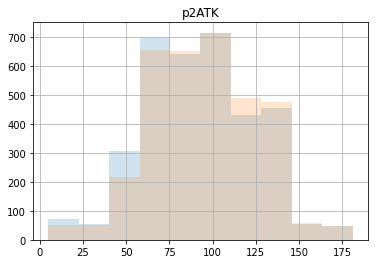

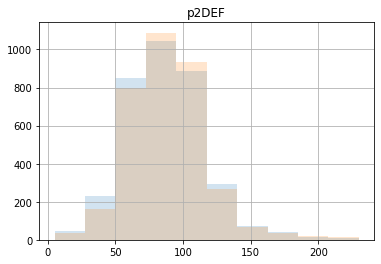

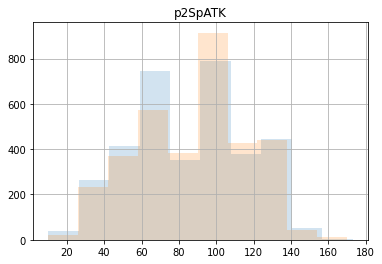

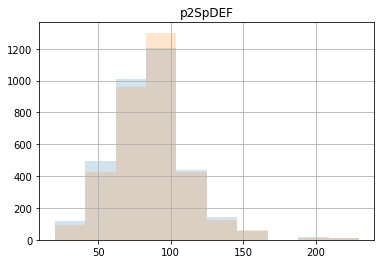

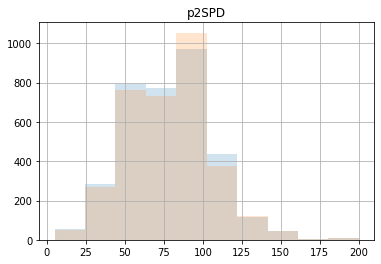

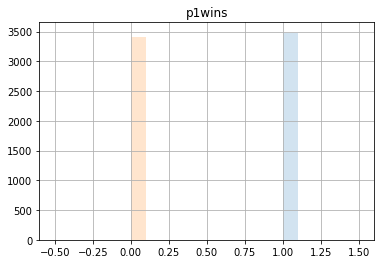

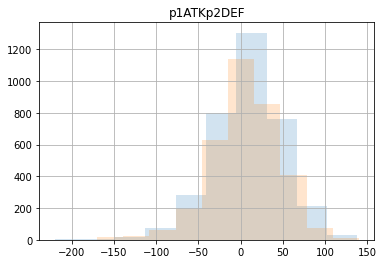

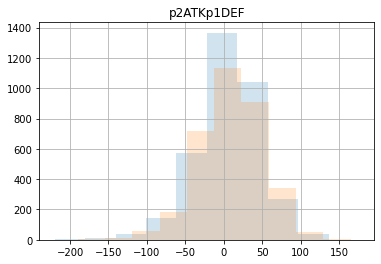

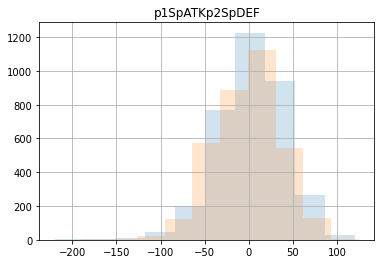

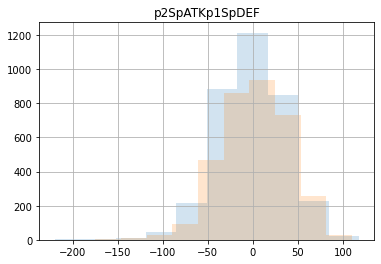

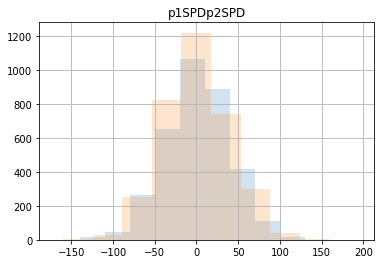

In [19]:
from matplotlib import pyplot as plt

y = df['p1wins']
for col in df.columns: 
    df.loc[ df['p1wins'] == 1, col].hist(alpha=0.2)
    df.loc[ df['p1wins'] == 0, col].hist(alpha=0.2)
    plt.title(col)
    plt.show()

## Modelling 
Trying:  
- kNN  
- logistic regression  
- decision tree  

with hyperparameters optimasation and ROC & AUC evaluation, defined as 2 functions for simplification on codes 

## Hyperparameters Optimasation

In [20]:
from sklearn.model_selection import GridSearchCV

def GridSearch_train(learner, grid: dict, X_train, y_train, showAll: bool=False):
    '''
    learner: ML algorithm class \n
    grid: hyperparameters in dictionary with keywords \n
    X_train, y_train: training data \n
    showAll: boolean for showing all details in .cv_results_, default False (showing only combination of hyperparameters and mean_test_score, mean_train_score) \n
    returns results (mean_test_score, mean_train_score) for each combination of hyperparameters
    ''' 
    model = GridSearchCV(estimator=learner, param_grid=grid, return_train_score=True)
    model.fit(X_train, y_train)
    if showAll: 
        return pd.DataFrame( model.cv_results_ )
    return pd.DataFrame( model.cv_results_ )[['params', 'mean_test_score', 'mean_train_score']]

## ROC and AUC Evaluation

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay

def showROC(y_train, y_test, y_pred_train_proba, y_pred_test_proba, title: str='unknown learner'): 
    '''
    y_train: training data (label) \n
    y_test: testing data (label) \n
    y_pred_train_proba: model predicting training data, in .predict_proba() \n
    y_pred_test_proba: model predicting test data, in .predict_proba() \n
    returns AUC and ROC plot of both \n
    only works with label_set = {0, 1} and 1 is True
    '''
    tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train, y_pred_train_proba[:, 1])
    test_fpr, test_tpr, test_threshold = roc_curve(y_test, y_pred_test_proba[:, 1])
    RocCurveDisplay(fpr=tr_fpr, tpr=tr_tpr).plot(name=f'train_{title}: AUC={round(auc(tr_fpr, tr_tpr), 3)}')
    RocCurveDisplay(fpr=test_fpr, tpr=test_tpr).plot(name=f'test_{title}: AUC={round(auc(test_fpr, test_tpr), 3)}')
    pass

### kNN
1. naive kNN (all default hyperparameters)
2. with hyperparameters optimasation

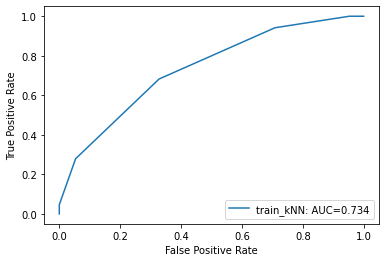

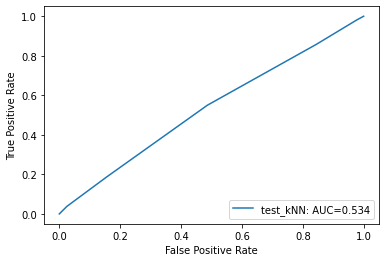

In [22]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier()
kNN.fit(X_train_scaled, y_train)
y_pred_kNN = kNN.predict(X_test_scaled)
y_score_train_kNN = kNN.predict_proba(X_train_scaled)
y_score_test_kNN = kNN.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_kNN, y_pred_test_proba=y_score_test_kNN, title='kNN')

In [23]:
grid_kNN = {
    'n_neighbors': [2500, 2750, 3000] 
    }
GridSearch_train(learner=KNeighborsClassifier(), grid=grid_kNN, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,{'n_neighbors': 2500},0.507928,0.510983
1,{'n_neighbors': 2750},0.512000,0.509228
2,{'n_neighbors': 3000},0.510186,0.512171


## LogisticRegression
1. naive LogisticRegression (all default hyperparameters)
2. with hyperparameters optimasation

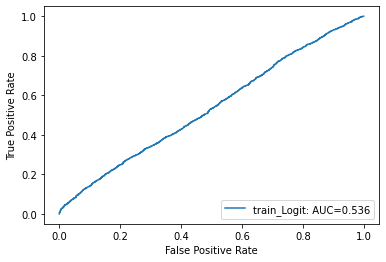

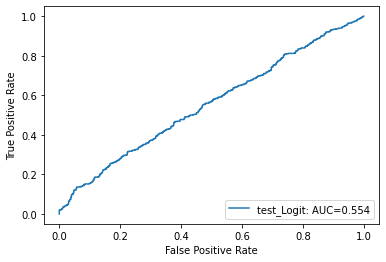

In [24]:
from sklearn.linear_model import LogisticRegression

Logit = LogisticRegression()
Logit.fit(X_train_scaled, y_train)
y_pred_Logit = Logit.predict(X_test_scaled)
y_score_train_Logit = Logit.predict_proba(X_train_scaled)
y_score_test_Logit = Logit.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_Logit, y_pred_test_proba=y_score_test_Logit, title='Logit')

In [25]:
grid_Logit = {
    'penalty': ['elasticnet'], 
    'solver': ['saga'],
    'l1_ratio': [0.25, 0.5, 0.75]
    }
GridSearch_train(learner=LogisticRegression(), grid=grid_Logit, X_train=X_train_scaled, y_train=y_train)

C:\Users\Jacky\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jacky\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jacky\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jacky\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,params,mean_test_score,mean_train_score
0,"{'l1_ratio': 0.25, 'penalty': 'elasticnet', 's...",0.511776,0.518116
1,"{'l1_ratio': 0.5, 'penalty': 'elasticnet', 'so...",0.512682,0.518456
2,"{'l1_ratio': 0.75, 'penalty': 'elasticnet', 's...",0.513134,0.518569


## DecisionTree
1. naive DecisionTree (all default hyperparameters)
2. with hyperparameters optimasation

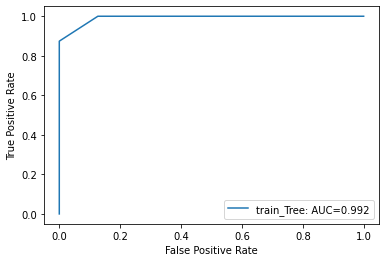

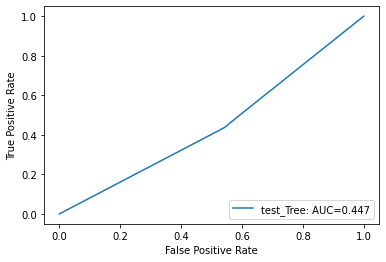

In [26]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier()
Tree.fit(X_train_scaled, y_train)
y_pred_Tree = Tree.predict(X_test_scaled)
y_score_train_Tree = Tree.predict_proba(X_train_scaled)
y_score_test_Tree = Tree.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_Tree, y_pred_test_proba=y_score_test_Tree, title='Tree')

In [27]:
grid_Tree = {
    'max_depth': [2, 5, 10, 20], 
    'min_samples_leaf': [5, 25, 50, 100, 1000], 
    }
GridSearch_train(learner=DecisionTreeClassifier(), grid=grid_Tree, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'min_samples_leaf': 5}",0.501356,0.534024
1,"{'max_depth': 2, 'min_samples_leaf': 25}",0.501356,0.534024
2,"{'max_depth': 2, 'min_samples_leaf': 50}",0.501356,0.534024
3,"{'max_depth': 2, 'min_samples_leaf': 100}",0.502261,0.532156
4,"{'max_depth': 2, 'min_samples_leaf': 1000}",0.516304,0.531193
5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.511550,0.571219
6,"{'max_depth': 5, 'min_samples_leaf': 25}",0.509738,0.570030
7,"{'max_depth': 5, 'min_samples_leaf': 50}",0.509513,0.570142
8,"{'max_depth': 5, 'min_samples_leaf': 100}",0.509286,0.563462
9,"{'max_depth': 5, 'min_samples_leaf': 1000}",0.516304,0.531193


working
___

## $f_m$ Optimisation
This is a measure of how good a particular threshold value is:   
$$ 
\begin{align}
    f_m &= \text{TPR} - m \times \text{FPR} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{\text{cost of negative}}{\text{cost of positive}} \\
    \text{threshold}_{best} &= \mathrm{argmax}\ f_m
\end{align}
$$
Sometimes:  
$$
\begin{align}
    \text{cost of negative} &= \text{cost of False positive} - \text{cost of True negative} \\
    \text{cost of positive} &= \text{cost of False negative} - \text{cost of True positive} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{C_{FP}-C_{TN}}{C_{FN}-C_{TP}}
\end{align}
$$
$\text{cost of negative}$ and $\text{cost of positive}$ are pre-determined values and usually we guess them based on the consequences for getting negative or positive results.  
So, within a set of values for threshold, the higher $f_m$ value, the better threshold. 

In [59]:
def fmOptimisation(prevalence: float, threshold: np.ndarray, FPR: np.ndarray, TPR: np.ndarray, cost_negative: float=2, cost_positive:float=1): 
    '''
    '''
    m = (1-prevalence)/prevalence * cost_negative/cost_positive
    fm = TPR - m*FPR
    best_threshold = threshold[ np.argmax(fm) ]
    return best_threshold

In [60]:
prevalence_Tree = np.sum( y_pred_Tree==1 )/len(y_pred_Tree)
fpr_Tree, tpr_Tree, threshold_Tree = roc_curve(y_test, y_score_test_Tree[:, 1])

fmOptimisation(prevalence=prevalence_Tree, threshold=threshold_Tree, FPR=fpr_Tree, TPR=tpr_Tree)

2.0